In [1]:
# Install required packages
!pip3 install pandas numpy matplotlib seaborn scikit-learn groq python-dotenv tqdm transformers requests torch -q 


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# API setup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import tqdm
import time
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import datetime

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)


## 1. Load Dataset

In [3]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_sentiment
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Zero-Shot Prompt Design

**Prompt Strategy**: Simple, direct instruction with no examples. Enforces strict JSON output format.

In [4]:
def create_zero_shot_prompt(sentence):
    """
    Creates a zero-shot prompt for sentiment classification.
    No examples provided - model relies on pretrained knowledge.
    """
    prompt = f"""You are a financial sentiment analysis expert. Analyze the sentiment of financial statements with precision.

Task: Classify the sentiment of the following financial statement as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, failed ventures, layoffs, legal issues
- Neutral: Factual statements with no clear financial impact, routine announcements, or balanced mixed signals

Financial Statement:
"{sentence}"

Return ONLY strictly JSON in this exact format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence"
}}
"""
    return prompt


# Test prompt
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
print("=" * 80)
print("ZERO-SHOT PROMPT EXAMPLE")
print("=" * 80)
print(create_zero_shot_prompt(test_sentence))

ZERO-SHOT PROMPT EXAMPLE
You are a financial sentiment analysis expert. Analyze the sentiment of financial statements with precision.

Task: Classify the sentiment of the following financial statement as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, failed ventures, layoffs, legal issues
- Neutral: Factual statements with no clear financial impact, routine announcements, or balanced mixed signals

Financial Statement:
"Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."

Return ONLY strictly JSON in this exact format:
{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence"
}



## 3. Model Inference Functions

In [5]:
def call_ollama(prompt, model_name, temperature=0.0):
    """
    Call Ollama models locally via Ollama API for Llama, Qwen, Deepseek.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model_name,
        "prompt": prompt,
        "options": {"temperature": temperature},
        "stream": False
    }
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        result = response.json()
        return result.get("response", None)
    except Exception as e:
        print(f"Ollama error: {str(e)[:100]}")
        return None

def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract sentiment with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None

print("✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)")

✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)


In [6]:
# Test API calls with a sample sentence
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
test_prompt = create_zero_shot_prompt(test_sentence)

print("=" * 80)
print("Testing llama3.1:8b...")
print("=" * 80)
llama3_response = call_ollama(test_prompt, model_name="llama3.1:8b")
if llama3_response:
    print(f"✓ Response received (length: {len(llama3_response)})")
    print(f"Response: {llama3_response[:500]}")
    try:
        parsed = json.loads(llama3_response)
        print(f"✓ Parsed successfully: {parsed}")
    except Exception as e:
        print(f"✗ Failed to parse response as JSON: {e}")
else:
    print("✗ llama3.1:8b call failed - no response received")

Testing llama3.1:8b...
✓ Response received (length: 161)
Response: {
    "sentiment": "positive",
    "confidence": 0.9,
    "rationale": "Operating profit increased by EUR 4.4 mn, indicating financial improvement and growth."
}
✓ Parsed successfully: {'sentiment': 'positive', 'confidence': 0.9, 'rationale': 'Operating profit increased by EUR 4.4 mn, indicating financial improvement and growth.'}


In [7]:
print("\n" + "=" * 80)
print("Testing qwen3:8b...")
print("=" * 80)
qwen3_response = call_ollama(test_prompt, model_name="qwen3:8b")
if qwen3_response:
    print(f"✓ Response received (length: {len(qwen3_response)})")
    print(f"Response: {qwen3_response[:500]}")
    parsed = parse_response(qwen3_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ qwen3:8b call failed - no response received")


Testing qwen3:8b...
✓ Response received (length: 193)
Response: {
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating financial improvement and growth."
}
✓ Parsed successfully: {'sentiment': 'positive', 'confidence': 0.95, 'rationale': 'Operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating financial improvement and growth.'}


In [8]:
print("\n" + "=" * 80)
print("Testing deepseek-r1:8b...")
print("=" * 80)
deepseek_response = call_ollama(test_prompt, model_name="deepseek-r1:8b")
if deepseek_response:
    print(f"✓ Response received (length: {len(deepseek_response)})")
    print(f"Response: {deepseek_response[:500]}")
    parsed = parse_response(deepseek_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ deepseek-r1:8b call failed - no response received")


Testing deepseek-r1:8b...
✓ Response received (length: 194)
Response: ```json
{
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating financial improvement."
}
```
✓ Parsed successfully: {'sentiment': 'positive', 'confidence': 0.95, 'rationale': 'Operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating financial improvement.'}


## 4. Run Experiments

### E1: ollama/llama3.1:8b (Zero-Shot)

This experiment (E1) uses the Llama3.1:8b model in a zero-shot setting to classify financial sentiment. The results and variables are updated for clarity and consistency with the new naming convention.

In [9]:
# Run on 200 dataset
E1_df = df.head(200).copy()

# E1: llama3.1:8b (Zero-Shot)
print("Running E1: llama3.1:8b (Zero-Shot)...")
E1_results = []

for idx, row in tqdm.tqdm(E1_df.iterrows(), total=len(E1_df), desc="E1 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            E1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            E1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)  # Rate limiting

E1_results_df = pd.DataFrame(E1_results)
print(f"\n✓ E1 completed: {len(E1_results_df)} predictions")
display(E1_results_df.head())

Running E1: llama3.1:8b (Zero-Shot)...


E1 Progress: 100%|██████████| 200/200 [1:32:06<00:00, 27.63s/it]   


✓ E1 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.8,The statement provides factual information abo...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.9,Componenta's net sales doubled and it moved fr...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.9,The financial statement reports significant in...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.9,Operating profit increased by 49% from EUR 8.7...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.9,The operating profit has increased from EUR 18...


### E2: ollama/qwen3:8b (Zero-Shot)

This experiment (E2) uses the Qwen3:8b model in a zero-shot setting. All variables and comments are updated for the E2 experiment.

In [10]:
# E2: qwen3:8b (Zero-Shot)
print("Running E2: qwen3:8b (Zero-Shot)...")
E2_results = []

for idx, row in tqdm.tqdm(E1_df.iterrows(), total=len(E1_df),  desc="E2 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            E2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            E2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

E2_results_df = pd.DataFrame(E2_results)
print(f"\n✓ E2 completed: {len(E2_results_df)} predictions")
display(E2_results_df.head())

Running E2: qwen3:8b (Zero-Shot)...


E2 Progress: 100%|██████████| 200/200 [1:14:52<00:00, 22.46s/it]


✓ E2 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.70,The statement presents factual information abo...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,The statement highlights significant revenue g...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement highlights significant increases...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,The statement highlights a significant increas...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The statement highlights a significant increas...


### E3: ollama/deepseek-r1:8b (Zero-Shot)

In [11]:
# E3: deepseek-r1:8b (Zero-Shot)
print("Running E3: deepseek-r1:8b (Zero-Shot)...")
e3_results = []

for idx, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df),  desc="E3 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            e3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    else:
        e3_results.append(
            {
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "Model error",
            }
        )

e3_df = pd.DataFrame(e3_results)
print(f"\n✓ E3 completed: {len(e3_df)} predictions")
display(e3_df.head())

Running E3: deepseek-r1:8b (Zero-Shot)...


E3 Progress: 100%|██████████| 200/200 [1:39:10<00:00, 29.75s/it]   


✓ E3 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.60,The statement provides factual information abo...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,The statement highlights significant revenue g...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement reports significant increases in...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.90,Operating profit increased significantly from ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased significantly from ...


## 5. Calculate Metrics

In [12]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_true, y_pred),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df

# Calculate metrics for all experiments
e1_metrics, e1_cm, e1_valid = calculate_metrics(e1_df, "E1: llama3.1:8b")
e2_metrics, e2_cm, e2_valid = calculate_metrics(e2_df, "E2: qwen3:8b")
e3_metrics, e3_cm, e3_valid = calculate_metrics(e3_df, "E3: deepseek-r1:8b")

# Create metrics comparison table
metrics_df = pd.DataFrame([e1_metrics, e2_metrics, e3_metrics])

print("\n" + "=" * 80)
print("ZERO-SHOT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


ZERO-SHOT PERFORMANCE COMPARISON


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E1: llama3.1:8b,1.000,1.0000,1.0000,1.0000
1,E2: qwen3:8b,1.000,1.0000,1.0000,1.0000
2,E3: deepseek-r1:8b,0.995,0.9533,0.9167,0.9974


## 6. Visualize Results

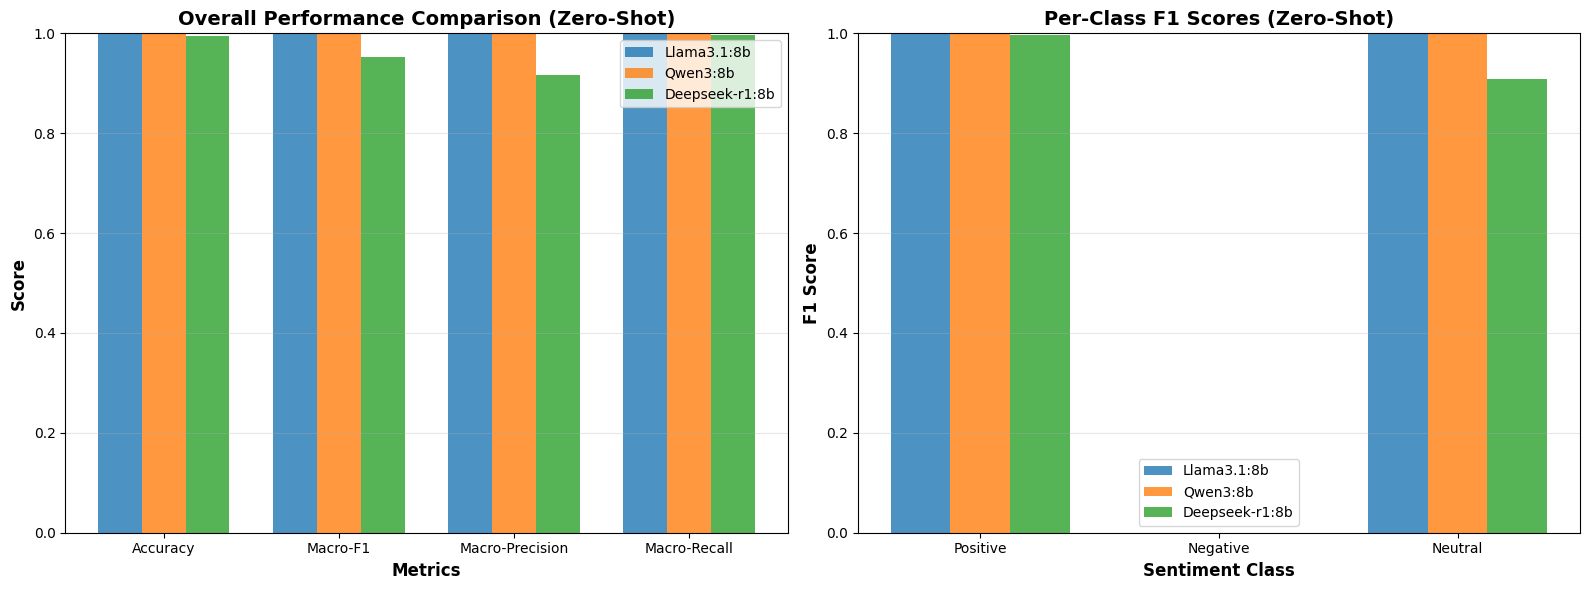

In [13]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e1_metrics, "Llama3.1:8b"),
        (e2_metrics, "Qwen3:8b"),
        (e3_metrics, "Deepseek-r1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Zero-Shot)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e1_metrics, "Llama3.1:8b"),
        (e2_metrics, "Qwen3:8b"),
        (e3_metrics, "Deepseek-r1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Zero-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("zero_shot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

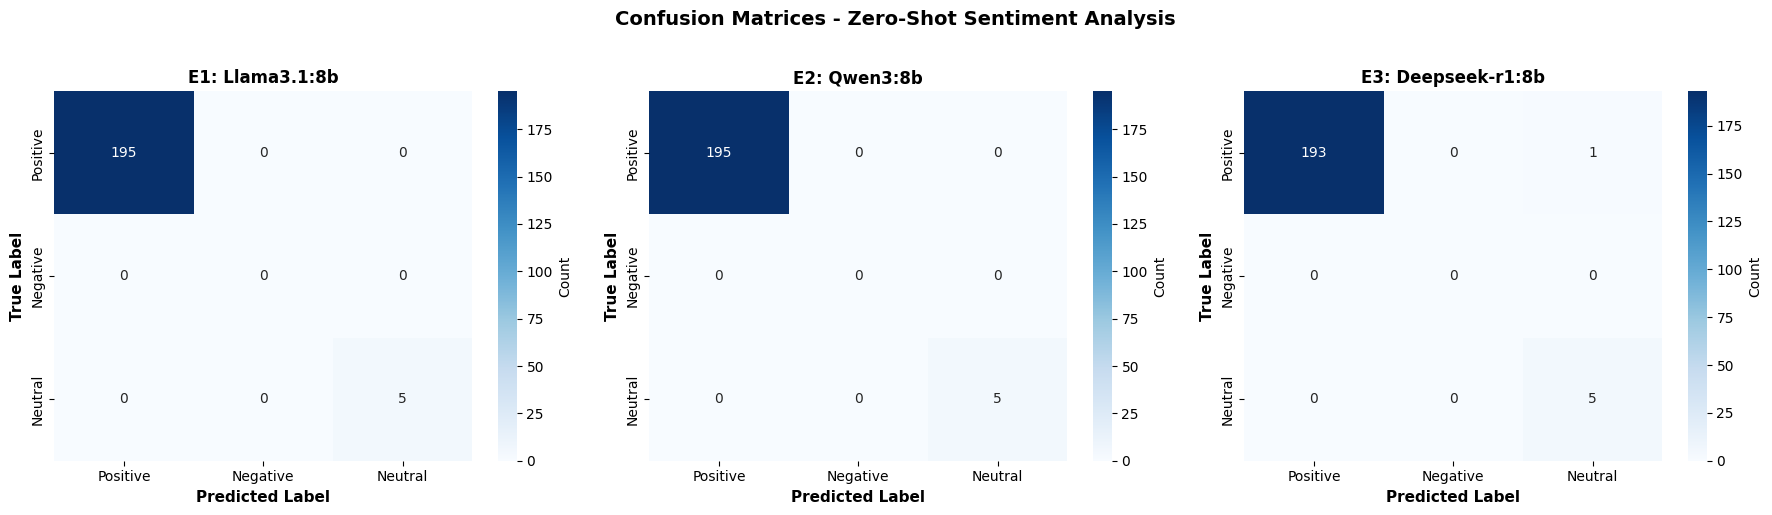

In [14]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e1_cm, "E1: Llama3.1:8b"),
        (e2_cm, "E2: Qwen3:8b"),
        (e3_cm, "E3: Deepseek-r1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Zero-Shot Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Classification Reports

In [15]:
# Print detailed classification reports
for df_result, exp_name in [
    (e1_valid, "E1: Llama3.1:8b"),
    (e2_valid, "E2: Qwen3:8b"),
    (e3_valid, "E3: Deepseek-r1:8b"),
]:
    print("\n" + "=" * 80)
    print(f"CLASSIFICATION REPORT: {exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Class-wise Metrics Summary Table
print("\n" + "=" * 80)
print("CLASS-WISE METRICS SUMMARY")
print("=" * 80)

summary_data = []
for metrics, model in [
    (e1_metrics, "Llama3.1:8b"),
    (e2_metrics, "Qwen3:8b"),
    (e3_metrics, "Deepseek-r1:8b"),
]:
    summary_data.append(
        {
            "Model": model,
            "Pos_P": metrics["Positive_Precision"],
            "Pos_R": metrics["Positive_Recall"],
            "Pos_F1": metrics["Positive_F1"],
            "Neg_P": metrics["Negative_Precision"],
            "Neg_R": metrics["Negative_Recall"],
            "Neg_F1": metrics["Negative_F1"],
            "Neu_P": metrics["Neutral_Precision"],
            "Neu_R": metrics["Neutral_Recall"],
            "Neu_F1": metrics["Neutral_F1"],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\nPer-Class Metrics (P=Precision, R=Recall, F1=F1-Score):")
display(summary_df.round(4))


CLASSIFICATION REPORT: E1: Llama3.1:8b
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      1.00      1.00         5

    accuracy                           1.00       200
   macro avg       0.67      0.67      0.67       200
weighted avg       1.00      1.00      1.00       200


CLASSIFICATION REPORT: E2: Qwen3:8b
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      1.00      1.00         5

    accuracy                           1.00       200
   macro avg       0.67      0.67      0.67       200
weighted avg       1.00      1.00      1.00       200


CLASSIFICATION REPORT: E3: Deepseek-r1:8b
              precision    recall  f1-score   support

    Positive       1.00      0.99      1.00       194
    Negat

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and bei

,Model,Pos_P,Pos_R,Pos_F1,Neg_P,Neg_R,Neg_F1,Neu_P,Neu_R,Neu_F1
0,Llama3.1:8b,1.0,1.0000,1.0000,0.0,0.0,0.0,1.0000,1.0,1.0000
1,Qwen3:8b,1.0,1.0000,1.0000,0.0,0.0,0.0,1.0000,1.0,1.0000
2,Deepseek-r1:8b,1.0,0.9948,0.9974,0.0,0.0,0.0,0.8333,1.0,0.9091


## 8. Save Results

In [18]:
import datetime
# Save detailed results
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

e1_df.to_csv(f"e1_llama3.1:8b_zero_shot_{timestamp}.csv", index=False)
e2_df.to_csv(f"e2_qwen3:8b_zero_shot_{timestamp}.csv", index=False)
e3_df.to_csv(f"e3_deepseek-r1:8b_zero_shot_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"zero_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - e1_llama3.1:8b_zero_shot_{timestamp}.csv")
print(f"  - e2_qwen3:8b_zero_shot_{timestamp}.csv")
print(f"  - e3_deepseek-r1:8b_zero_shot_{timestamp}.csv")
print(f"  - zero_shot_metrics_summary_{timestamp}.csv")
print(f"  - zero_shot_performance_comparison.png")
print(f"  - zero_shot_confusion_matrices.png")


✓ Results saved with timestamp: 20260211_053519

Files created:
  - e1_llama3.1:8b_zero_shot_20260211_053519.csv
  - e2_qwen3:8b_zero_shot_20260211_053519.csv
  - e3_deepseek-r1:8b_zero_shot_20260211_053519.csv
  - zero_shot_metrics_summary_20260211_053519.csv
  - zero_shot_performance_comparison.png
  - zero_shot_confusion_matrices.png


## 9. Error Analysis

In [19]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (e1_valid, "E1: Llama3.1:8b"),
    (e2_valid, "E2: Qwen3:8b"),
    (e3_valid, "E3: Deepseek-r1:8b"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_sentiment"] != df_result["predicted_sentiment"]]

    # Count error types
    error_types = (
        errors.groupby(["true_sentiment", "predicted_sentiment"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Class-wise Performance Comparison
print("=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (e1_metrics, "Llama3.1:8b"),
    (e2_metrics, "Qwen3:8b"),
    (e3_metrics, "Deepseek-r1:8b"),
]:
    for sentiment in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": sentiment,
                "Precision": metrics[f"{sentiment}_Precision"],
                "Recall": metrics[f"{sentiment}_Recall"],
                "F1-Score": metrics[f"{sentiment}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

# Identify weakest class per model
print("\n" + "=" * 80)
print("WEAKEST CLASS IDENTIFICATION")
print("=" * 80)
for metrics, model_name in [
    (e1_metrics, "Llama3.1:8b"),
    (e2_metrics, "Qwen3:8b"),
    (e3_metrics, "Deepseek-r1:8b"),
]:
    f1_scores = {
        "Positive": metrics["Positive_F1"],
        "Negative": metrics["Negative_F1"],
        "Neutral": metrics["Neutral_F1"],
    }
    weakest = min(f1_scores, key=f1_scores.get)
    print(f"{model_name}: Weakest class = {weakest} (F1={f1_scores[weakest]:.4f})")

ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS

E1: Llama3.1:8b
--------------------------------------------------------------------------------

Total Errors: 0 / 200 (0.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count



E2: Qwen3:8b
--------------------------------------------------------------------------------

Total Errors: 0 / 200 (0.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count



E3: Deepseek-r1:8b
--------------------------------------------------------------------------------

Total Errors: 1 / 199 (0.50%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count
0,positive,neutral,1



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.60
  Sentence: Shares of Standard Chartered ( STAN ) rose 1.2 % in the FTSE 100 , while Royal Bank of Scotland ( RBS ) shares rose 2 % ...
  Rationale: The statement reports share price movements without providing reasons or context about underlying financial performance, making it a factual observation rather than a clear positive or negative sentiment.
CLASS-WISE PERFORMANCE BREAKDOWN

Precision by Class:


Model,Deepseek-r1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0,0.0
Neutral,0.8333,1.0,1.0
Positive,1.0000,1.0,1.0



Recall by Class:


Model,Deepseek-r1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0,0.0
Neutral,1.0000,1.0,1.0
Positive,0.9948,1.0,1.0



F1-Score by Class:


Model,Deepseek-r1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0,0.0
Neutral,0.9091,1.0,1.0
Positive,0.9974,1.0,1.0



WEAKEST CLASS IDENTIFICATION
Llama3.1:8b: Weakest class = Negative (F1=0.0000)
Qwen3:8b: Weakest class = Negative (F1=0.0000)
Deepseek-r1:8b: Weakest class = Negative (F1=0.0000)


## 10. Confidence Analysis

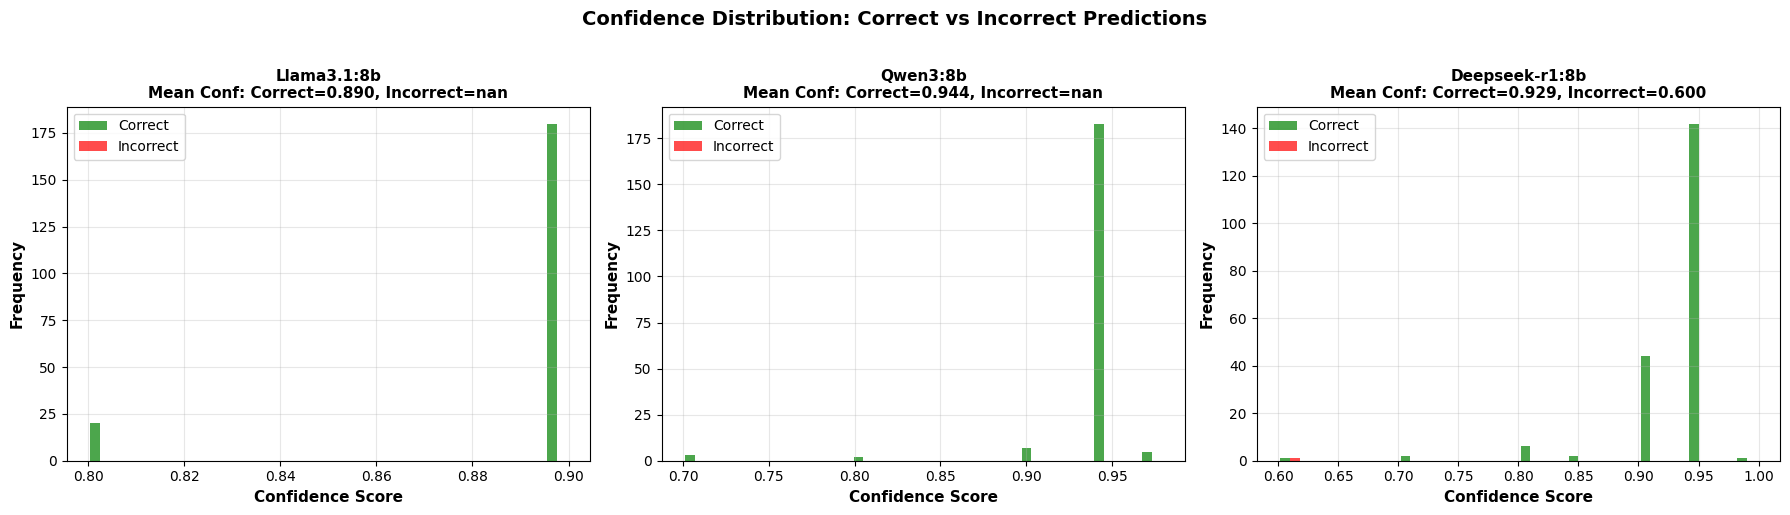


CONFIDENCE CALIBRATION ANALYSIS

E1: Llama3.1:8b:
  Average Confidence (Correct): 0.8900
  Average Confidence (Incorrect): nan
  Calibration Gap: nan
  Total Correct: 200 / 200

  Confidence by Predicted Class:
    Positive: 0.8918 (n=195)
    Neutral: 0.8200 (n=5)

E2: Qwen3:8b:
  Average Confidence (Correct): 0.9437
  Average Confidence (Incorrect): nan
  Calibration Gap: nan
  Total Correct: 200 / 200

  Confidence by Predicted Class:
    Positive: 0.9464 (n=195)
    Neutral: 0.8400 (n=5)

E3: Deepseek-r1:8b:
  Average Confidence (Correct): 0.9293
  Average Confidence (Incorrect): 0.6000
  Calibration Gap: 0.3293
  Total Correct: 198 / 199

  Confidence by Predicted Class:
    Positive: 0.9308 (n=193)
    Neutral: 0.8250 (n=6)


In [20]:
# Confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e1_valid, "Llama3.1:8b"), (e2_valid, "Qwen3:8b"), (e3_valid, "Deepseek-r1:8b")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)
for df_result, exp_name in [
    (e1_valid, "E1: Llama3.1:8b"),
    (e2_valid, "E2: Qwen3:8b"),
    (e3_valid, "E3: Deepseek-r1:8b"),
]:
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    avg_conf_correct = df_result[df_result["correct"]]["confidence"].mean()
    avg_conf_incorrect = df_result[~df_result["correct"]]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"\n{exp_name}:")
    print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
    print(f"  Average Confidence (Incorrect): {avg_conf_incorrect:.4f}")
    print(f"  Calibration Gap: {calibration_gap:.4f}")
    print(f"  Total Correct: {df_result['correct'].sum()} / {len(df_result)}")

    # Confidence by sentiment class
    print(f"\n  Confidence by Predicted Class:")
    for sentiment in ["positive", "negative", "neutral"]:
        class_df = df_result[df_result["predicted_sentiment"] == sentiment]
        if len(class_df) > 0:
            print(
                f"    {sentiment.capitalize()}: {class_df['confidence'].mean():.4f} (n={len(class_df)})"
            )